In [14]:
import glob 
import os
rosbag_paths = glob.glob("/app/data/BJ_juice1/*.bag")
print(len(rosbag_paths))

536


NameError: name '__file__' is not defined

/
 ├── data
 │   ├── action (92146, 7) float32
 │   ├── img (92146, 96, 96, 3) uint8
 │   └── state (92146, 7) float32
 └── meta
     └── episode_ends (536,) int64


NameError: name 'os' is not defined

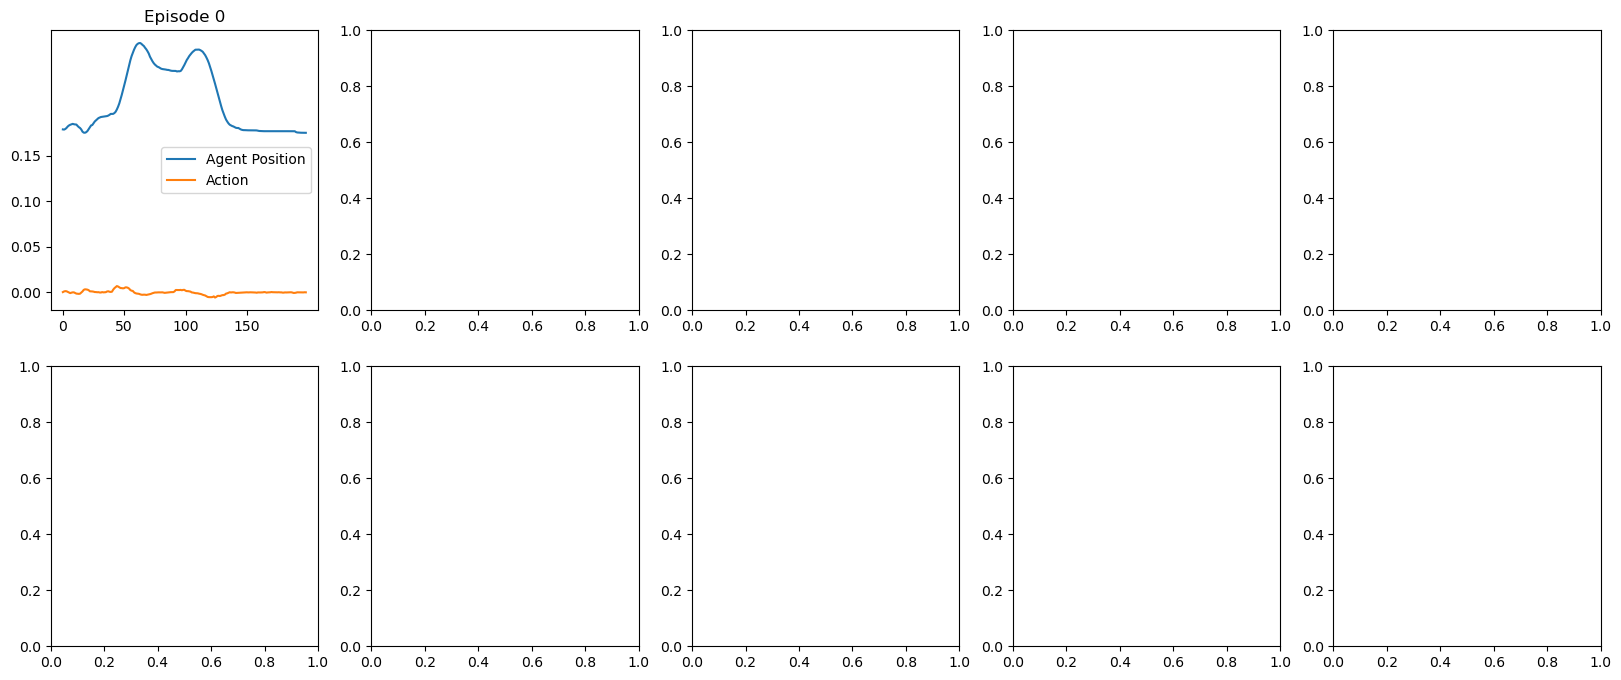

In [1]:
import cv2
import zarr
import numpy as np
import matplotlib.pyplot as plt

# video_folder = "/app/data/BJ_juice1/video"

# os.makedirs(video_folder,exist_ok=True)
    
# draw dataset
dataset_path = "/app/data/BJ_juice1/zarr/BJ_juice1.zarr"
# dataset_path = "/app/data/pusht/pusht_cchi_v7_replay.zarr"
dataset_root = zarr.open(dataset_path, 'r')
# dataset_root0 = zarr.open(dataset_path0, 'r')
print(dataset_root.tree())
train_image_data = dataset_root['data']['img'][:]

train_image_data = np.moveaxis(train_image_data, -1, 1)
train_data = {
    'agent_pos': dataset_root['data']['state'][:],
    'action': dataset_root['data']['action'][:]
}
episode_ends = dataset_root['meta']['episode_ends'][:10]

# plot first 10 episodes and record the video
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    start_idx = 0
    if i > 0:
        start_idx = episode_ends[i-1]
    end_idx = episode_ends[i]
    episode_length = end_idx - start_idx
    ax = axs[i//5, i%5]
    ax.set_title(f"Episode {i}")
    ax.plot(train_data['agent_pos'][start_idx:end_idx,0], label='Agent Position')
    ax.plot(train_data['action'][start_idx:end_idx,0], label='Action')
    # 保证每张图之间的x轴刻度一致,y轴刻度一致,y轴一格为50。而且每个图的50长度是一样的
    ax.set_xticks(np.arange(0, 200, 50))
    ax.set_yticks(np.arange(0, 0.2, 0.05))
    # ax.set_aspect('equal')
    ax.legend()
    
    # 提取帧数据
    frames = train_image_data[start_idx:end_idx]
    frames = np.moveaxis(frames, 1, -1)  # 确保帧数据格式为 (height, width, channels)
    frames = frames.astype(np.uint8)

    # 存储为MP4文件
    video_path = os.path.join(video_folder, f"episode_{i}.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 使用mp4编码
    out = cv2.VideoWriter(video_path, fourcc, 10, (frames.shape[2], frames.shape[1]))  # 设置帧速率和帧大小
    
    for frame in frames:
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # 将RGB转换为BGR格式
    out.release()
    
    

plt.tight_layout()
plt.show()


/
 ├── data
 │   ├── action (14056, 7) float32
 │   ├── img01 (14056, 256, 256, 3) float32
 │   ├── img02 (14056, 256, 256, 3) float32
 │   └── state (14056, 7) float32
 └── meta
     └── episode_ends (82,) int64


NameError: name 'os' is not defined

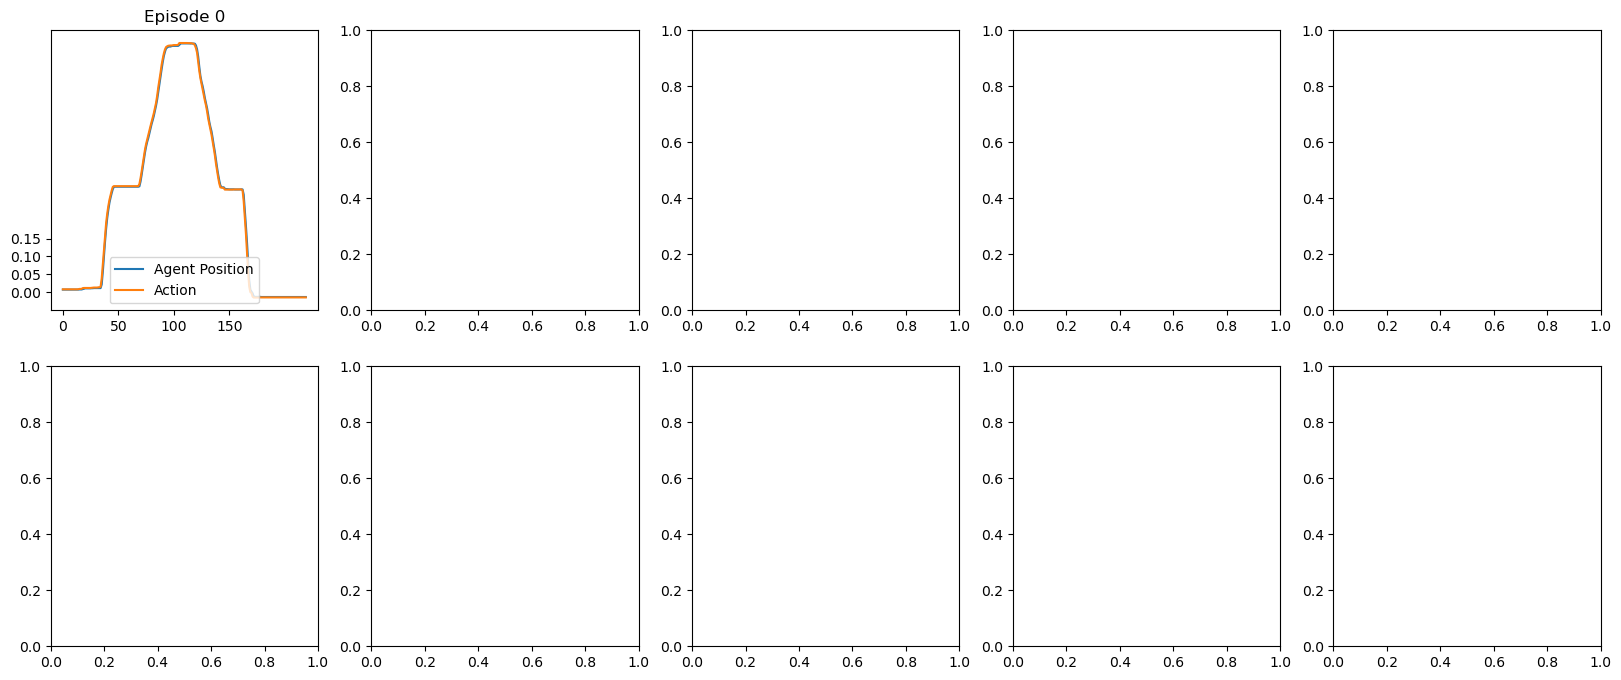

In [2]:
import cv2
import zarr
import numpy as np
import matplotlib.pyplot as plt

# video_folder = "/app/data/BJ_juice1/video"

# os.makedirs(video_folder,exist_ok=True)
    
# draw dataset
dataset_path = "/app/data/zarr/SongLingPickPlace.zarr"
dataset_root = zarr.open(dataset_path, 'r')
# dataset_root0 = zarr.open(dataset_path0, 'r')
print(dataset_root.tree())

train_image_data01 = dataset_root['data']['img01']
train_image_data02 = dataset_root['data']['img02']

# train_image_data = np.moveaxis(train_image_data, -1, 1)
train_data = {    
    'img01':train_image_data01,
    'img02':train_image_data02,
    'agent_pos': dataset_root['data']['state'],
    'action': dataset_root['data']['action']
}
episode_ends = dataset_root['meta']['episode_ends']

# plot first 10 episodes and record the video
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    start_idx = 0
    if i > 0:
        start_idx = episode_ends[i-1]
    end_idx = episode_ends[i]
    episode_length = end_idx - start_idx
    ax = axs[i//5, i%5]
    ax.set_title(f"Episode {i}")
    ax.plot(train_data['agent_pos'][start_idx:end_idx,0], label='Agent Position')
    ax.plot(train_data['action'][start_idx:end_idx,0], label='Action')
    # 保证每张图之间的x轴刻度一致,y轴刻度一致,y轴一格为50。而且每个图的50长度是一样的
    ax.set_xticks(np.arange(0, 200, 50))
    ax.set_yticks(np.arange(0, 0.2, 0.05))
    # ax.set_aspect('equal')
    ax.legend()
    
    # 提取帧数据
    frames = train_image_data[start_idx:end_idx]
    frames = np.moveaxis(frames, 1, -1)  # 确保帧数据格式为 (height, width, channels)
    frames = frames.astype(np.uint8)

    # 存储为MP4文件
    video_path = os.path.join(video_folder, f"episode_{i}.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 使用mp4编码
    out = cv2.VideoWriter(video_path, fourcc, 10, (frames.shape[2], frames.shape[1]))  # 设置帧速率和帧大小
    
    for frame in frames:
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # 将RGB转换为BGR格式
    out.release()
    
    

plt.tight_layout()
plt.show()
